# Etapa 6:  Predicción mediante aprendizaje automático

Space X anuncia en su página web lanzamientos de cohetes Falcon 9 con un coste de 62 millones de dólares; otros proveedores cuestan más de 165 millones de dólares cada uno, gran parte del ahorro se debe a que Space X puede reutilizar la primera etapa. Por lo tanto, si podemos determinar si la primera etapa aterrizará, podemos determinar el coste de un lanzamiento. Esta información puede utilizarse si una empresa alternativa quiere pujar contra Space X por el lanzamiento de un cohete.   En este laboratorio, crearás una línea de aprendizaje automático para predecir si la primera etapa aterrizará dados los datos de los laboratorios anteriores.

## Objetivos

Realizar un análisis exploratorio de los datos y determinar las etiquetas de formación

* Crear una columna para la clase
* Estandarizar los datos
* Dividir en datos de entrenamiento y datos de prueba

\-Encontrar el mejor hiperparámetro para SVM, árboles de clasificación y regresión logística

* Encontrar el método que mejor se comporta utilizando los datos de prueba


***


## Importar librerias y Definir Funciones Auxiliares


In [70]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

Esta función sirve para visualizar la matriz de confusión.


In [71]:
def plot_confusion_matrix(y,y_predict):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); 
    ax.set_xlabel('Valores predecidos')
    ax.set_ylabel('Valores reales')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['no aterrizó', 'aterrizó']); ax.yaxis.set_ticklabels(['no aterrizó', 'aterrizó'])

## Cargar el dataframe


Cargar los datos


In [72]:
data = pd.read_csv("dataset_part_2.csv")
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Payload,Orbit,LaunchSite,LandingOutcome,Flights,GridFins,...,Legs,LandingPad,Block,Customers,Mission_Outcome,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6123.547647,Dragon Qualification Unit,LEO,CCSFS SLC 40,None None,1,False,...,False,NaN,1.0,SpaceX,True,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,COTS Demo Flight 2,LEO,CCSFS SLC 40,None None,1,False,...,False,NaN,1.0,NASA(COTS),True,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,CRS-2,ISS,CCSFS SLC 40,None None,1,False,...,False,NaN,1.0,NASA (CRS),True,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,CASSIOPE,PO,VAFB SLC 4E,False Ocean,1,False,...,False,NaN,1.0,MDA,True,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,SES-8,GTO,CCSFS SLC 40,None None,1,False,...,False,NaN,1.0,SES,True,0,B1004,-80.577366,28.561857,0


Al conjunto de datos anterior hemos aplicado una transformación one-hot para poder realizar las tareas de machine learning correctamente

In [73]:
X = pd.read_csv('dataset_one-hot.csv')

X.head(100)

,Unnamed: 0.2,Unnamed: 0,Unnamed: 0.1,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,0,0,0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,1,1,1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,2,2,2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,3,3,3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,4,4,4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,85,85,85,86.0,15400.000000,2.0,5.0,2.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
86,86,86,86,87.0,15400.000000,3.0,5.0,2.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
87,87,87,87,88.0,15400.000000,6.0,5.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
88,88,88,88,89.0,15400.000000,3.0,5.0,2.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


## Tarea  1


Crea un array NumPy a partir de la columna `Class` en `data`, aplicando el método `to_numpy()` y luego
asignarlo a la variable `Y`, asegúrese de que la salida es una serie Pandas (sólo un paréntesis df\['nombre de la columna'\]).

In [74]:
#Inserta tu código aquí

Y = data['Class'].to_numpy()

## Tarea  2


Normalice los datos en `X` usando al función `fit_transform` y luego reasígnelos a la variable `X` utilizando la transformación proporcionada a continuación.


In [75]:
scaler = preprocessing.StandardScaler()

In [76]:
#Inserta tu código aquí
X = scaler.fit_transform(X)

Dividimos los datos en datos de entrenamiento y de prueba utilizando la función `train_test_split`.   Los datos de entrenamiento se dividen en datos de validación, un segundo conjunto utilizado para los datos de entrenamiento; luego se entrenan los modelos y se seleccionan los hiperparámetros utilizando la función `GridSearchCV`.


## Tarea  3


Utilice la función `train_test_split` para dividir los datos X e Y en datos de entrenamiento y de prueba como hicimos en la práctica de regresión. Establezca el parámetro test_size en 0,2 y random_state en 2. Los datos de entrenamiento y los datos de prueba deben asignarse a las siguientes etiquetas.


`X_train, X_test, Y_train, Y_test`


In [77]:
#Inserta tu código aquí
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=2)

## Tarea  4


* Cree un objeto de regresión logística. 
* Luego crea un objeto GridSearchCV `logreg_cv` con el objeto de regresión lógistica, los parametros descritos, `scoring='accuracy'` y `cv = 10`.  
* Ajusta el objeto GridSearchCV para encontrar los mejores parámetros del diccionario `parameters`.


In [78]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

In [79]:
#Inserta tu código aquí
regresion_logistica = LogisticRegression()
logreg_cv = GridSearchCV(regresion_logistica, parameters, scoring='accuracy', cv=10)

logreg_cv.fit(X_train,Y_train)



GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']},
             scoring='accuracy')

Mostramos los mejores parámetros utilizando el atributo de datos `best_params_` y la precisión en los datos de validación utilizando el atributo de datos `best_score_`.


In [80]:
print("Mejores parámetros ", logreg_cv.best_params_)
print("Precisión de la regresión logística:", logreg_cv.best_score_)

Mejores parámetros  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Precisión de la regresión logística: 0.8214285714285714


## Tarea  5


Calcule la precisión en los datos de prueba utilizando el método `score`sobre `X_test` e `Y_test`:


In [81]:
#Inserta tu código aquí
logreg_cv.score(X_test,Y_test)

0.8333333333333334

Predice `X_test` y guardalo en `y_pred`

In [82]:
#Inserta tu código aquí
y_pred = logreg_cv.predict(X_test)
print(y_pred)

[1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1]


Compara `y_pred` con `Y_test` con una matriz de confusión:

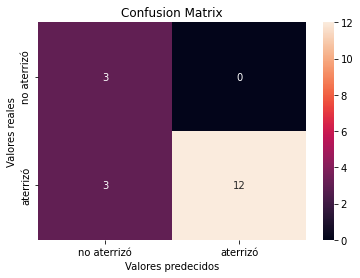

In [83]:
#Inserta tu código aquí
plot_confusion_matrix(y_pred,Y_test)


Al examinar la matriz de confusión, vemos que la regresión logística puede distinguir entre las diferentes clases.  Vemos que el principal problema son los falsos positivos.


## Tarea  6


* Crea un objeto [Support Vector Machine](https://scikit-learn.org/stable/modules/svm.html) y guardalo en svm 
* Luego crea un objeto `GridSearchCV` `svm_cv` con el objeto de svm, los parametros descritos, `scoring='accuracy'` y  `cv=10`.  
* Ajusta el objeto para encontrar los mejores parámetros del diccionario `parameters`.


In [84]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}

In [85]:
#Inserta tu código aquí

support_vector_machine = SVC()
svm_cv = GridSearchCV(support_vector_machine, parameters, scoring='accuracy', cv=10)








Siempre se hace el fit sobre los datos de entrenamiento, de lo contario estariamos haciendo overfiting

In [86]:
#Inserta tu código aquí
svm_cv.fit(X_train,Y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')},
             scoring='accuracy')

In [87]:
print("Mejores parámetros: ", svm_cv.best_params_)
print("Accuracy :", svm_cv.best_score_)

Mejores parámetros:  {'C': 1.0, 'gamma': 1.0, 'kernel': 'sigmoid'}
Accuracy : 0.8357142857142856


## Tarea  7


Calcule la precisión en los datos de prueba utilizando el método `score`sobre `X_test` e `Y_test`:


Siempre es el nombre del modelo y le pasas los datos nuevos los que nunca ha visto con el objetivo de predecir X test y comparar.

esto da un numero que e sla diferencia entre aciertos vs el numero partido de predicciones (seria el porcentaje de error)

In [88]:
#Inserta tu código aquí
svm_cv.score(X_test,Y_test)

0.8333333333333334

Podemos representar la matriz de confusión:

Es lo mismmo, predecir en base a todas las columnas si el cohete va a aterrizar bien o mal. Una vez tenemos la yhat (prediccion) la comparamos la real contra la prediccion, podemos ver la distribucion (18) de las cuales 11 decia que iba a aterrizar y solo acerto 10. cuantas decia que iba a aterrizar 5 y se ha equivocado en 2. 

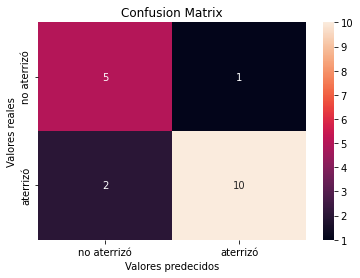

In [89]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## Tarea  8


* Crea un objeto clasificador de árbol de decisión
* Y luego crea un objeto GridSearchCV tree_cv con el objeto clasificador de árbol de decisión, los parametros descritos, `scoring='accuracy'` y  cv = 10.
* Ajuste el objeto para encontrar los mejores parámetros a partir de los parámetros del diccionario.

In [90]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

In [91]:
#Inserta tu código aquí
arbol_decision = DecisionTreeClassifier()
tree_cv = GridSearchCV(arbol_decision, parameters, scoring='accuracy', cv=10)

In [92]:
#Inserta tu código aquí
tree_cv.fit(X_train,Y_train)

Se han truncado las últimas 5000 líneas del flujo de salida.
/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `ma

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']},
             scoring='accuracy')

In [93]:
print("Mejores parámetros:", tree_cv.best_params_)
print("Accuracy for decision tree classifier:", tree_cv.best_score_)

Mejores parámetros: {'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 5, 'splitter': 'random'}
Accuracy for decision tree classifier: 0.8625


## Tarea  9


Calcula la precisión de tree_cv en los datos de prueba utilizando el método `score`:


In [94]:
#Inserta tu código aquí
tree_cv.score(X_test,Y_test)

0.8333333333333334

Podemos representar la matriz de confusión


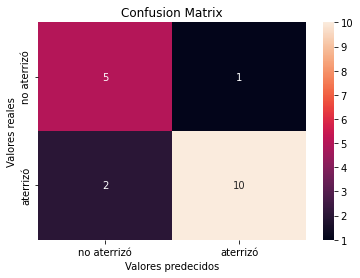

In [66]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test, yhat)

## Tarea  10


* Crear un objeto k vecinos más cercanos 
* Y luego crear un objeto `GridSearchCV` `knn_cv` con el objeto k vecinos más cercanos, los parametros descritos, `scoring='accuracy'` y  cv = 10. 
* Ajuste el objeto para encontrar los mejores parámetros del diccionario `parameters`.


In [112]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

In [114]:
#Inserta tu código aquí
knn_cv = KNeighborsClassifier()
knn2_cv = GridSearchCV(knn_cv, parameters, scoring='accuracy', cv=10)

In [118]:
#Inserta tu código aquí
knn2_cv.fit(X_train,Y_train)


GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]},
             scoring='accuracy')

In [119]:
print("Mejores parámetros: ",knn2_cv.best_params_)
print("Accuracy for k nearest neighbors:",knn2_cv.best_score_)

Mejores parámetros:  {'algorithm': 'auto', 'n_neighbors': 4, 'p': 2}
Accuracy for k nearest neighbors: 0.8464285714285713


## Tarea  11


Calcula la precisión de knn_cv en los datos de prueba utilizando el método `score`:


In [120]:
#Inserta tu código aquí
knn2_cv.score(X_test,Y_test)

0.7777777777777778

Podemos representar la matriz de confusión


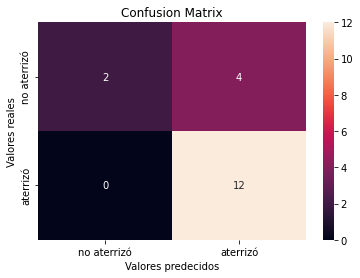

In [121]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## Tarea  12


Encuentra el método que mejor funciona. Para ello crea un dataframe con los los resultados y los algoritmos. Muestra los diferentes resultado en un gráfico de barras.

Comparamos todos los modelos predictivos y vemos cual se ha ajustado mejor a los datos, teniamos que resetear el indice, y renombrar las columnas, eso lo hacemos y ya podriamos ver la grafica. En la sig grafica comparamos los 4 y vemos cual ha salido mejor, generalmente funciona mejor el arbol de decision para estos datos. 
Dependiendo de los datos que tengamos tenemos que repetir todo el proceso de buscar cuales son los mejores hiperparametros y quedarnos con el modelo que mejor funcione para este conjunto de datos. 

In [123]:
algorithms = {'KNN':knn2_cv.best_score_,'Decision Tree':tree_cv.best_score_,'Logistic Regression':logreg_cv.best_score_,'SVM':svm_cv.best_score_}


Aqui deben saltar las alarmas cuando veamos las letras en negrita porque esta mostrando un indice. 

Y cuando este mostrando el resultado por pantalla sigifica que no se ha guardado. 
Te lo guardas, le das al play y no muestras nada si quieres verlo print de la variable.


In [130]:
algo_df = pd.DataFrame.from_dict(algorithms, orient='index', columns=['Accuracy'])
#Inserta aquí tu código new
#Resetea el indice de el df
algo_df=algo_df.reset_index()
#Renombre las columnas con: {'index': 'Algorithm'}
algo_df = algo_df.rename(columns={'index': 'Algorithm'})
algo_df

,Algorithm,Accuracy
0,KNN,0.846429
1,Decision Tree,0.862500
2,Logistic Regression,0.821429
3,SVM,0.835714


In [129]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.bar(algo_df, x='Algorithm', y='Accuracy', hover_data=['Algorithm', 'Accuracy'], color='Accuracy', color_continuous_scale='rdylbu')
fig.update_layout(title='Algorithm vs. Accuracy', xaxis_title='Algorithm', yaxis_title='Accuracy' )
fig.show()